# 11. Variational Auto-Encoder

_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._

## Prepare environment

In [1]:
import os

import tensorflow as tf

from keras import (
    layers,
    datasets,
    metrics,
    optimizers,
    callbacks,
    Model,
    losses,
    Sequential,
)

import numpy as np

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from skimage.metrics import structural_similarity

from collections import Counter

import json

import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

2025-04-10 20:26:31.906328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744309591.926077  148039 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744309591.932955  148039 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 20:26:31.952926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [2]:
EPOCHS = 25
EARLY_STOPPING_PATIENCE = 5
BATCH_SIZE = 128
LATENT_DIM = 14
KL_WEIGHT = 2.0
LEARNING_RATE = 1e-4
OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE)

I0000 00:00:1744309597.946382  148039 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


### Prepare logs

In [3]:
PARENT_LOGS_PATH = "logs"
ITERATION = 5

current_logs_path = os.path.join(PARENT_LOGS_PATH, str(ITERATION))
os.makedirs(current_logs_path, exist_ok=True)
print(current_logs_path)

logs = {
    "iteration" : ITERATION,
    "summary" : "Increase KL Weight from 1 to 2"
}

logs/5


In [4]:
logs["EPOCHS"] = EPOCHS
logs["EARLY_STOPPING_PATIENCE"] = EARLY_STOPPING_PATIENCE
logs["BATCH_SIZE"] = BATCH_SIZE
logs["LATENT_DIM"] = LATENT_DIM
logs["KL_WEIGHT"] = KL_WEIGHT
logs["LEARNING_RATE"] = LEARNING_RATE
logs["OPTIMIZER"] = OPTIMIZER.name

## Prepare dataset

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

### Check if dataset is not evenly distributed

In [6]:
class_distribution = Counter(y_train)
print(class_distribution)

norm_labels_distr = {k: v / len(y_train) for k, v in class_distribution.items()}
print(norm_labels_distr)

def gini_coefficient(probabilities):
    probabilities = np.sort(probabilities)
    n = len(probabilities)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * probabilities)) / (n * np.sum(probabilities))

gini = gini_coefficient(list(norm_labels_distr.values()))
print(f"Gini coefficient for class distribution of train images: {gini}")

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
{5: 0.09035, 0: 0.09871666666666666, 4: 0.09736666666666667, 1: 0.11236666666666667, 9: 0.09915, 2: 0.0993, 3: 0.10218333333333333, 6: 0.09863333333333334, 7: 0.10441666666666667, 8: 0.09751666666666667}
Gini coefficient for class distribution of train images: 0.027326666666666676


## Train Variational Auto-Encoder

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

### Encoder

In [8]:
inputs = layers.Input(shape=(28, 28))
Z = layers.Flatten()(inputs)
Z = layers.Dense(150, activation="relu")(Z)
Z = layers.Dense(100, activation="relu")(Z)
codings_mean = layers.Dense(LATENT_DIM)(Z)  # μ
codings_log_var = layers.Dense(LATENT_DIM)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

### Decoder

In [9]:
decoder_inputs = layers.Input(shape=[LATENT_DIM])
x = layers.Dense(100, activation="relu")(decoder_inputs)
x = layers.Dense(150, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = layers.Reshape((28, 28))(x)
variational_decoder = Model(inputs=decoder_inputs, outputs=outputs)

### Loss layer

In [10]:
class VAELossLayer(layers.Layer):
    def __init__(self, beta, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.total_loss_tracker = metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def call(self, inputs, codings_mean, codings_log_var, reconstructions):
        # 1. Reconstruction Loss
        reconstruction_loss = tf.reduce_mean(
            losses.binary_crossentropy(inputs, reconstructions)
        )
        reconstruction_loss *= tf.cast(tf.reduce_prod(inputs.shape[1:]), tf.float32) # Scale for pixel-wise loss

        # 2. KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.square(codings_mean) - tf.exp(codings_log_var),
            axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss)  # Average over the batch

        # 3. Total VAE Loss
        total_loss = reconstruction_loss + self.beta * kl_loss

        # Add the total loss to the model
        self.add_loss(total_loss)

        # Add loss values to metrics for monitoring
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)

        return reconstructions

### Variational Auto-Encoder

In [11]:
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
outputs = VAELossLayer(beta=KL_WEIGHT)(inputs, codings_mean, codings_log_var, reconstructions)
variational_ae = Model(inputs=inputs, outputs=outputs)

### Compilation and training

In [12]:
early_stopping_cb = callbacks.EarlyStopping(
    patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, mode="min"
)

variational_ae.compile(optimizer=OPTIMIZER)
history = variational_ae.fit(
    x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, x_test), callbacks=[early_stopping_cb]
)

Epoch 1/25


I0000 00:00:1744309601.687428  148137 service.cc:148] XLA service 0x7f2a580113c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744309601.687477  148137 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-10 20:26:41.726092: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744309601.933728  148137 cuda_dnn.cc:529] Loaded cuDNN version 90700


 33/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 0.8821 - loss: 541.6686 - reconstruction_loss: 539.9044 - total_loss: 541.6686

I0000 00:00:1744309605.026857  148137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - kl_loss: 8.5919 - loss: 385.1149 - reconstruction_loss: 367.9312 - total_loss: 385.1147 - val_kl_loss: 4.1736 - val_loss: 211.0972 - val_reconstruction_loss: 202.7572 - val_total_loss: 211.1045
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.6398 - loss: 206.1614 - reconstruction_loss: 198.8818 - total_loss: 206.1614 - val_kl_loss: 3.8964 - val_loss: 193.1568 - val_reconstruction_loss: 185.4271 - val_total_loss: 193.2199
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 4.1674 - loss: 190.9520 - reconstruction_loss: 182.6172 - total_loss: 190.9520 - val_kl_loss: 5.4937 - val_loss: 181.3937 - val_reconstruction_loss: 170.4280 - val_total_loss: 181.4155
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 5.6542 - loss: 180.4955 - reconstruction_loss: 169.1870 - total_loss: 180.4955 - val_kl_loss: 6.7281 - val_loss: 173.1597 - val_reconstruction_loss: 159.7191 - val_total_loss: 173.1753
Epoch 5/25
469/46

In [13]:
best_epoch = early_stopping_cb.best_epoch
print(f"Best epoch: {best_epoch + 1}")

best_loss = history.history["val_loss"][best_epoch]
best_reconstruction_loss = history.history["val_reconstruction_loss"][best_epoch]
best_kl_loss = history.history["val_kl_loss"][best_epoch]

print(f"Best total loss: {best_loss}, reconstruction loss: {best_reconstruction_loss}, kl_loss: {best_kl_loss}")

logs["LOSS"] = best_loss
logs["RECONSTRUCTION"] = best_reconstruction_loss
logs["KL"] = best_kl_loss

Best epoch: 25
Best total loss: 135.605712890625, reconstruction loss: 109.59630584716797, kl_loss: 12.966657638549805


## Evaluation

### Learning curves

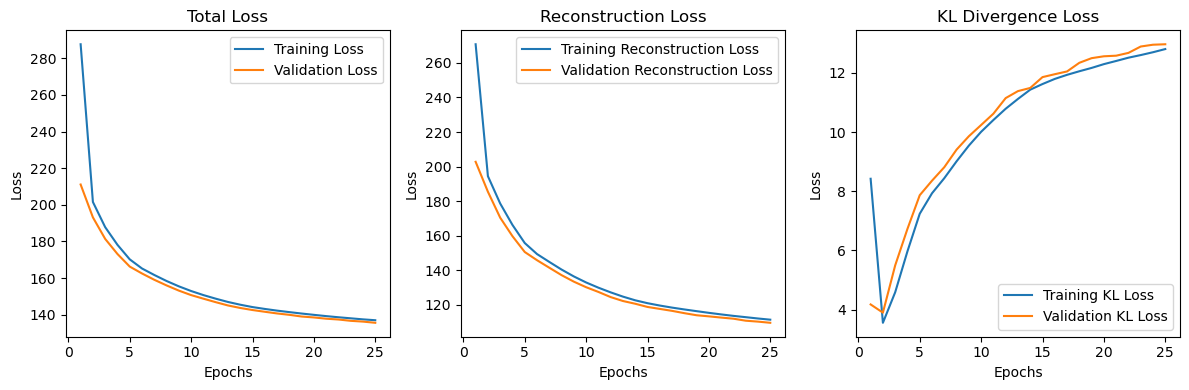

In [14]:
# Plotting the losses after training
total_loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']
val_loss = history.history.get('val_loss')
val_reconstruction_loss = history.history.get('val_reconstruction_loss')
val_kl_loss = history.history.get('val_kl_loss')

epochs_range = range(1, len(total_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, total_loss, label='Training Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, reconstruction_loss, label='Training Reconstruction Loss')
if val_reconstruction_loss:
    plt.plot(epochs_range, val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, kl_loss, label='Training KL Loss')
if val_kl_loss:
    plt.plot(epochs_range, val_kl_loss, label='Validation KL Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(current_logs_path, "learning_curves.png"))
plt.show()

### Train a very basic classifier on real MNIST data

It will help us with evaluating reconstructed and generated images.

In [15]:
def build_simple_classifier():
    model = Sequential([
        layers.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax') # 10 classes for MNIST digits
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

classifier = build_simple_classifier()
# Train on a subset (with more data accuracy/confidence is high even for not that clear images)
classifier.fit(x_train[:10000], y_train[:10000], epochs=5, batch_size=128, verbose=0)

### Reconstructions

#### Mean Squared Error

In [16]:
print("\nEvaluating Reconstruction Quality...")
reconstructed_sample = variational_ae.predict(x_test)

# Calculate Reconstruction Error (Proxy for visual quality)
reconstruction_mse = np.mean((x_test - reconstructed_sample)**2)
print(f"Mean Squared Error (MSE) on {len(x_test)} test samples: {reconstruction_mse:.6f}")
# Lower MSE generally means better reconstruction fidelity.
logs["MSE"] = reconstruction_mse


Evaluating Reconstruction Quality...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Mean Squared Error (MSE) on 10000 test samples: 0.026010


#### Mean True Confidence

How big of a confidence we get when predicting true labels on reconstructed images.

In [17]:
predictions = classifier.predict(reconstructed_sample)
true_confidence = [pred[y] for pred, y in zip(predictions, y_test)]
mean_true_confidence = np.mean(true_confidence)
print(f"Mean confidence of true labels on reconstructed images: {mean_true_confidence}")
logs["MTC"] = mean_true_confidence

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean confidence of true labels on reconstructed images: 0.7772930860519409


#### Mean Structural Similarity Index Measure (SSIM)

In [18]:
print("\nEvaluating the structural similarity index measure (SSIM)...")

ssim_scores = []
for i in range(len(x_test)):
    ssim = structural_similarity(x_test[i], reconstructed_sample[i], data_range=1)
    ssim_scores.append(ssim)
mean_ssim = np.mean(ssim_scores)
print(f"The mean structural similarity index measure (SSIM) on {len(x_test)} test samples: {mean_ssim}")
logs["MSSIM"] = mean_ssim


Evaluating the structural similarity index measure (SSIM)...
The mean structural similarity index measure (SSIM) on 10000 test samples: 0.6982468302372165


#### Peak Signal-to-Noise Ratio (PSNR)

Make sure that both input and output are normalized to (0,1), since we specify max_val as 1.0.

E.g. without Sigmoid function, output was exceeding these bounds.

- High PSNR (e.g., 40 dB or more)
- Good PSNR (e.g., 30-40 dB)
- Fair PSNR (e.g., 20-30 dB)
- Low PSNR (e.g., below 20 dB)

In [19]:
max_value = np.max(x_test)
min_value = np.min(x_test)

print(f"Max value: {max_value}")
print(f"Min value: {min_value}")

Max value: 1.0
Min value: 0.0


In [20]:
max_value = np.max(reconstructed_sample)
min_value = np.min(reconstructed_sample)

print(f"Max value: {max_value}")
print(f"Min value: {min_value}")

Max value: 0.9992826581001282
Min value: 6.1768544980693104e-21


In [21]:
# In case reconstructed sample exceeds (0, 1) bounds
cliped_reconstructed_sample = np.clip(reconstructed_sample, 0, 1)

psnr = tf.image.psnr(x_test, cliped_reconstructed_sample, max_val=1.0).numpy()
print(f"Peak Signal-to-Noise Ratio (PSNR) on {len(x_test)} test samples: {psnr}")
logs["PSNR"] = psnr

Peak Signal-to-Noise Ratio (PSNR) on 10000 test samples: 15.848565101623535


#### Plot reconstructions for visual inspection

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


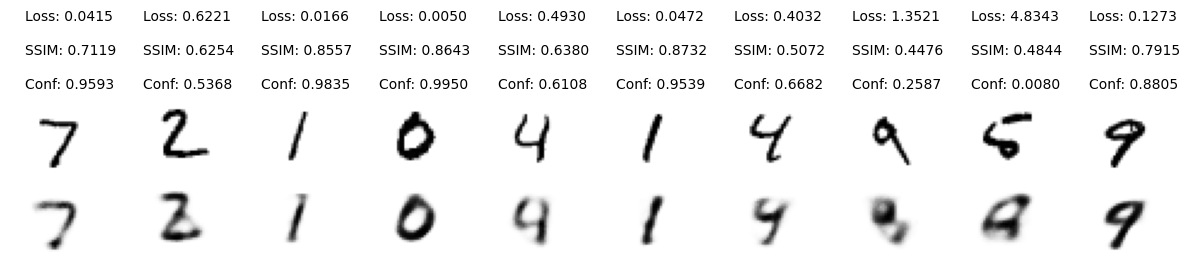

In [22]:
def plot_reconstructions(model, images, labels, n_images=10):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):

        plt.subplot(3, n_images, 1 + image_index)
        sample_prediction = classifier.predict(np.expand_dims(reconstructions[image_index], axis=0))
        sample_confidence = sample_prediction[0][labels[image_index]]
        plt.text(0.15, 0, "Conf: {:.4f}".format(sample_confidence))

        sample_ssmi = structural_similarity(images[image_index], reconstructions[image_index], data_range=1)
        plt.text(0.15, 0.5, "SSIM: {:.4f}".format(sample_ssmi))

        sample_loss, _ = classifier.evaluate(
            np.expand_dims(reconstructions[image_index], axis=0),
            np.expand_dims(labels[image_index], axis=0),
            verbose=0
        )
        plt.text(0.15, 1.0, "Loss: {:.4f}".format(sample_loss))
        plt.axis("off")

        plt.subplot(3, n_images, 1 + n_images + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")

        plt.subplot(3, n_images, 1 + 2 * n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_ae, images=x_test, labels=y_test)
plt.savefig(os.path.join(current_logs_path, "reconstructions.png"))
plt.show()

### Image Generation

In [23]:
codings = tf.random.normal(shape=[3 * 7, LATENT_DIM])
images = variational_decoder(codings).numpy()

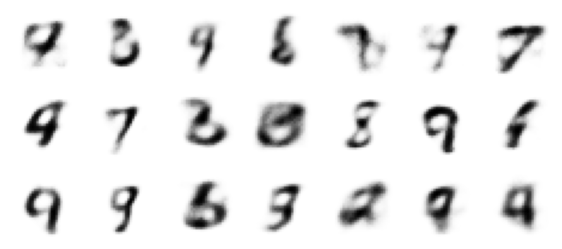

In [24]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.savefig(os.path.join(current_logs_path, "image_generation.png"))
plt.show()

#### Evaluate based on Simple Classifier

In [25]:
# Evaluate classifier on REAL test data (as a baseline)
_, real_accuracy = classifier.evaluate(x_test, y_test, verbose=0)
print(f"Simple classifier accuracy on REAL test data: {real_accuracy:.4f}")

# Generate a large batch of images
n_generated_for_eval = 5000
random_latent_vectors_eval = np.random.normal(size=(n_generated_for_eval, LATENT_DIM))
generated_images_eval = variational_decoder.predict(random_latent_vectors_eval)

# Predict labels for generated images
generated_predictions = classifier.predict(generated_images_eval)
generated_labels = np.argmax(generated_predictions, axis=1)
generated_confidence = np.mean(np.max(generated_predictions, axis=1))

# Score: Average confidence of the classifier on generated images.
# Higher confidence suggests the classifier "recognizes" the generated images better.
print(f"Average classifier confidence on {n_generated_for_eval} GENERATED images: {generated_confidence:.4f}")

# Mean classifier confidence
logs["MCC"] = generated_confidence

Simple classifier accuracy on REAL test data: 0.9200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Average classifier confidence on 5000 GENERATED images: 0.7048


#### Distribution of predicted labels for generated images

A good generator should produce all digits somewhat evenly.

In [26]:
print("Distribution of predicted labels for generated images:")
generated_labels_distr = dict(zip(np.histogram(generated_labels, bins=np.arange(11))[1], np.histogram(generated_labels, bins=np.arange(11))[0]))
print(generated_labels_distr)

Distribution of predicted labels for generated images:
{0: 366, 1: 395, 2: 512, 3: 707, 4: 551, 5: 266, 6: 476, 7: 610, 8: 648, 9: 469}


In [27]:
norm_generated_labels_distr = {k: v / n_generated_for_eval for k, v in generated_labels_distr.items()}

gini = gini_coefficient(list(norm_generated_labels_distr.values()))
print(f"Gini coefficient for class distribution of generated images: {gini}")
logs["GINI"] = gini

Gini coefficient for class distribution of generated images: 0.146


### Latent space exploration

#### Plot latent space (dimensionality reduced to 2)

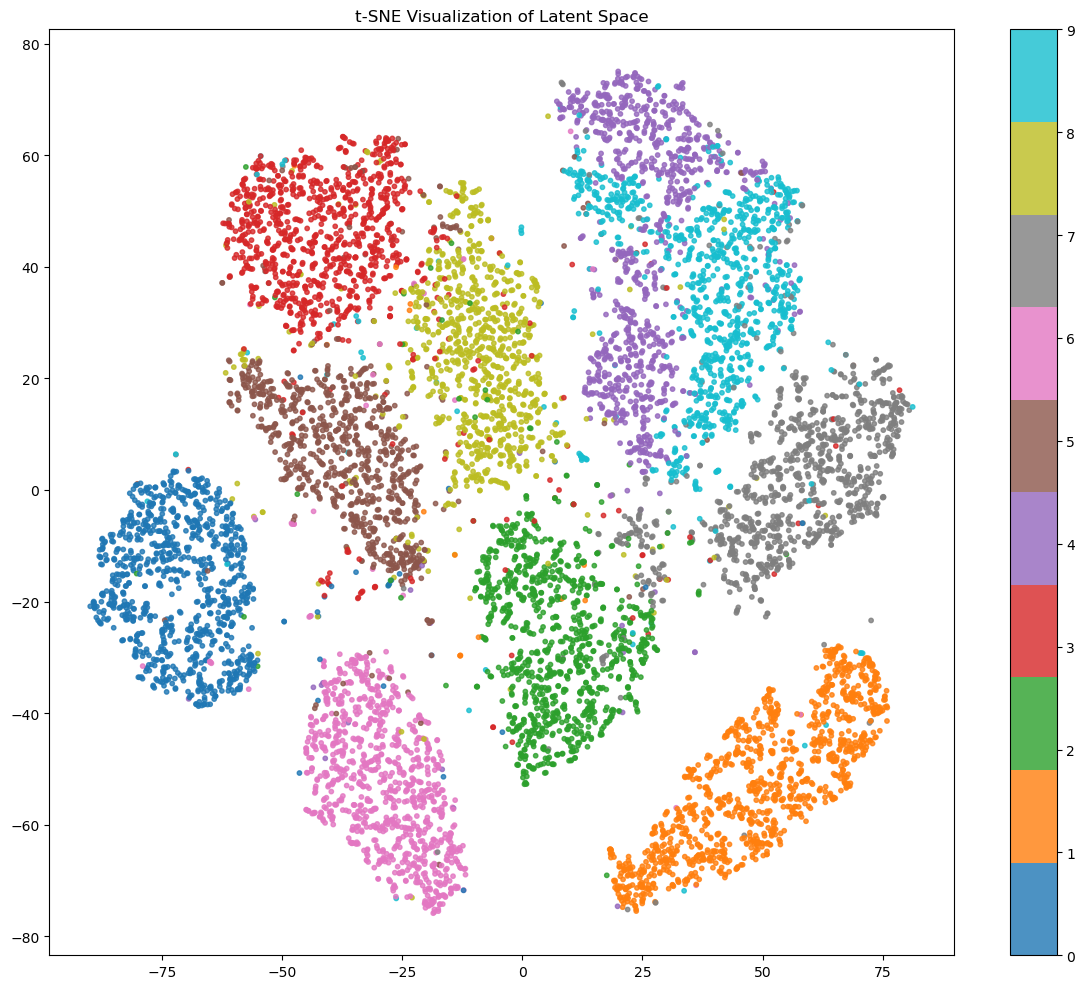

In [28]:
samples = x_test
labels = y_test

# Encode to latent space
codings_mean, codings_log_var, codings = variational_encoder(samples)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
z_tsne = tsne.fit_transform(codings_mean)

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
            cmap='tab10', s=10, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of Latent Space")
plt.tight_layout()
plt.savefig(os.path.join(current_logs_path, "latent_space.png"))
plt.show()

#### Average Variances per Latent Dimension

In [29]:
variances = np.exp(codings_log_var.numpy())

average_variances = np.mean(variances, axis=0)

print("Average Variances per Latent Dimension:")
for i, avg_var in enumerate(average_variances):
    print(f"Dimension {i}: {avg_var:.4f}")

Average Variances per Latent Dimension:
Dimension 0: 0.0619
Dimension 1: 0.2451
Dimension 2: 0.1959
Dimension 3: 0.7750
Dimension 4: 0.1205
Dimension 5: 0.1877
Dimension 6: 0.0719
Dimension 7: 0.1806
Dimension 8: 0.1814
Dimension 9: 0.0669
Dimension 10: 0.5586
Dimension 11: 0.0601
Dimension 12: 0.8445
Dimension 13: 0.1977


In [30]:
threshold = 1e-3  # Adjust this threshold as needed
unused_dimensions = np.where(average_variances < threshold)[0]
print(f"\nPotentially Unused Dimensions (below threshold {threshold}): {unused_dimensions}")


Potentially Unused Dimensions (below threshold 0.001): []


#### Adjusted Rand Index

In [31]:
# Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(codings_mean)

# Compute the ARI
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

logs["ARI"] = ari_score

Adjusted Rand Index (ARI): 0.46270385988962215


### Semantic interpolation between 2 images

In [32]:
codings = np.zeros([7, LATENT_DIM])
codings[:, 9] = np.linspace(-0.8, 0.8, 7) 
images = variational_decoder(codings).numpy()

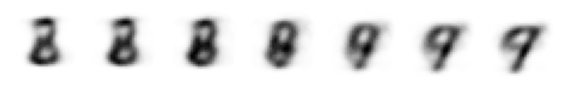

In [33]:
plot_multiple_images(images)
plt.savefig(os.path.join(current_logs_path, "sem_interpolation.png"))
plt.show()

## Save logs

In [34]:
logs

{'iteration': 5,
 'summary': 'Increase KL Weight from 1 to 2',
 'EPOCHS': 25,
 'EARLY_STOPPING_PATIENCE': 5,
 'BATCH_SIZE': 128,
 'LATENT_DIM': 14,
 'KL_WEIGHT': 2.0,
 'LEARNING_RATE': 0.0001,
 'OPTIMIZER': 'adam',
 'LOSS': 135.605712890625,
 'RECONSTRUCTION': 109.59630584716797,
 'KL': 12.966657638549805,
 'MSE': 0.026010152,
 'MTC': 0.7772931,
 'MSSIM': 0.6982468302372165,
 'PSNR': 15.848565,
 'MCC': 0.7047961,
 'GINI': 0.146,
 'ARI': 0.46270385988962215}

In [35]:
# Convert numpy types to native Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

logs_serializable = {k: convert_numpy_types(v) for k, v in logs.items()}

with open(os.path.join(current_logs_path, "logs.json"), "w", encoding="utf-8") as file:
    json.dump(logs_serializable, file, ensure_ascii=False, indent=4)

## Display all logs

In [36]:
log_folders = [folder for folder in os.listdir(PARENT_LOGS_PATH) if os.path.isdir(os.path.join(PARENT_LOGS_PATH, folder))]
log_file_paths = [os.path.join(PARENT_LOGS_PATH, folder, "logs.json") for folder in log_folders]

all_logs = []
for log_file_path in log_file_paths:
    file = open(log_file_path)
    json_logs = json.loads(file.read())
    df_logs = pd.DataFrame([json_logs])
    all_logs.append(df_logs)

df = pd.concat(all_logs)
df.to_csv(os.path.join(PARENT_LOGS_PATH, "logs.csv"), encoding='utf-8', index=False)